In [38]:
#cell 1
# --- Data Manipulation and Analysis ---
import pandas as pd
import numpy as np
import datetime # Added for dynamic year

# --- Data Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Machine Learning: Preprocessing ---
from sklearn.model_selection import train_test_split, GridSearchCV # Added GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- Machine Learning: Models ---
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import KMeans

# --- Machine Learning: Evaluation ---
from sklearn.metrics import mean_squared_error, r2_score

# --- General Settings ---
import warnings
warnings.filterwarnings('ignore')

In [39]:
# cell 2
from google.colab import files
import io
import pandas as pd

print("Please upload your 'Global YouTube Statistics.csv' file:")
# This opens the upload dialog
uploaded = files.upload()

# Check if any file was uploaded
if uploaded:
    # Get the name of the file that was *actually* uploaded
    actual_filename = list(uploaded.keys())[0]

    print(f'\nUser uploaded file "{actual_filename}" with length {len(uploaded[actual_filename])} bytes')

    # Load the dataset from the in-memory bytes
    try:
        data_buffer = io.BytesIO(uploaded[actual_filename])

        # --- IMPROVEMENT: Robust Encoding Handling ---
        try:
            # First try utf-8 (standard for international characters)
            df = pd.read_csv(data_buffer, encoding='utf-8')
        except UnicodeDecodeError:
            # If that fails, reset buffer and try latin-1 (common fallback)
            print("UTF-8 encoding failed, falling back to latin-1...")
            data_buffer.seek(0)
            df = pd.read_csv(data_buffer, encoding='latin-1')

        print("\nDataset loaded successfully!")
        print(f"The dataset has {df.shape[0]} rows and {df.shape[1]} columns.")

        # Display the first few rows
        print("\nDisplaying the first 5 rows:")
        display(df.head())

    except Exception as e:
        print(f"\nAn error occurred while processing the file: {e}")

else:
    print("\nError: No files were uploaded.")

Please upload your 'Global YouTube Statistics.csv' file:


Saving Global YouTube Statistics.csv to Global YouTube Statistics (3).csv

User uploaded file "Global YouTube Statistics (3).csv" with length 200279 bytes
UTF-8 encoding failed, falling back to latin-1...

Dataset loaded successfully!
The dataset has 995 rows and 28 columns.

Displaying the first 5 rows:


,rank,Youtuber,subscribers,video views,category,Title,uploads,Country,Abbreviation,channel_type,...,subscribers_for_last_30_days,created_year,created_month,created_date,Gross tertiary education enrollment (%),Population,Unemployment rate,Urban_population,Latitude,Longitude
0,1,T-Series,245000000,2.280000e+11,Music,T-Series,20082,India,IN,Music,...,2000000.0,2006.0,Mar,13.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880
1,2,YouTube Movies,170000000,0.000000e+00,Film & Animation,youtubemovies,1,United States,US,Games,...,NaN,2006.0,Mar,5.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
2,3,MrBeast,166000000,2.836884e+10,Entertainment,MrBeast,741,United States,US,Entertainment,...,8000000.0,2012.0,Feb,20.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
3,4,Cocomelon - Nursery Rhymes,162000000,1.640000e+11,Education,Cocomelon - Nursery Rhymes,966,United States,US,Education,...,1000000.0,2006.0,Sep,1.0,88.2,3.282395e+08,14.70,270663028.0,37.090240,-95.712891
4,5,SET India,159000000,1.480000e+11,Shows,SET India,116536,India,IN,Entertainment,...,1000000.0,2006.0,Sep,20.0,28.1,1.366418e+09,5.36,471031528.0,20.593684,78.962880


In [40]:
#cell 3
# --- Drop unnecessary columns ---
columns_to_drop = [
    'rank', 'Abbreviation', 'country_rank', 'created_month',
    'created_date', 'Gross tertiary education enrollment (%)',
    'Unemployment rate', 'Urban_population', 'Latitude', 'Longitude'
]
df = df.drop(columns=columns_to_drop)

# --- Handle Missing Values ---
# For categorical columns, fill with 'Unknown'
for col in df.select_dtypes(include=['object']).columns:
    df[col] = df[col].fillna("Unknown")

# For numerical columns, fill with the median value to avoid skewing the data
for col in df.select_dtypes(include=['int64', 'float']).columns:
    median_val = df[col].median()
    df[col] = df[col].fillna(median_val)

# --- Correct Data Types ---
# Convert relevant columns to integer type for cleaner analysis
for col in ['video views', 'uploads', 'subscribers']:
    df[col] = pd.to_numeric(df[col], errors='coerce').astype('int64')

# --- Remove illogical data points ---
# Remove channels with 0 video views as they are likely outliers or errors
df = df[df['video views'] > 0]
# Remove channels with creation years before YouTube's founding (2005)
df = df[df['created_year'] >= 2005]

# --- Sort and Reset Index for consistency ---
df = df.sort_values(by='subscribers', ascending=False).reset_index(drop=True)

print("Data cleaning complete.")
df.info()

Data cleaning complete.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 986 entries, 0 to 985
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Youtuber                          986 non-null    object 
 1   subscribers                       986 non-null    int64  
 2   video views                       986 non-null    int64  
 3   category                          986 non-null    object 
 4   Title                             986 non-null    object 
 5   uploads                           986 non-null    int64  
 6   Country                           986 non-null    object 
 7   channel_type                      986 non-null    object 
 8   video_views_rank                  986 non-null    float64
 9   channel_type_rank                 986 non-null    float64
 10  video_views_for_the_last_30_days  986 non-null    float64
 11  lowest_monthly_earnings           986 non-null 

EDA: Analyzing key distributions and relationships.


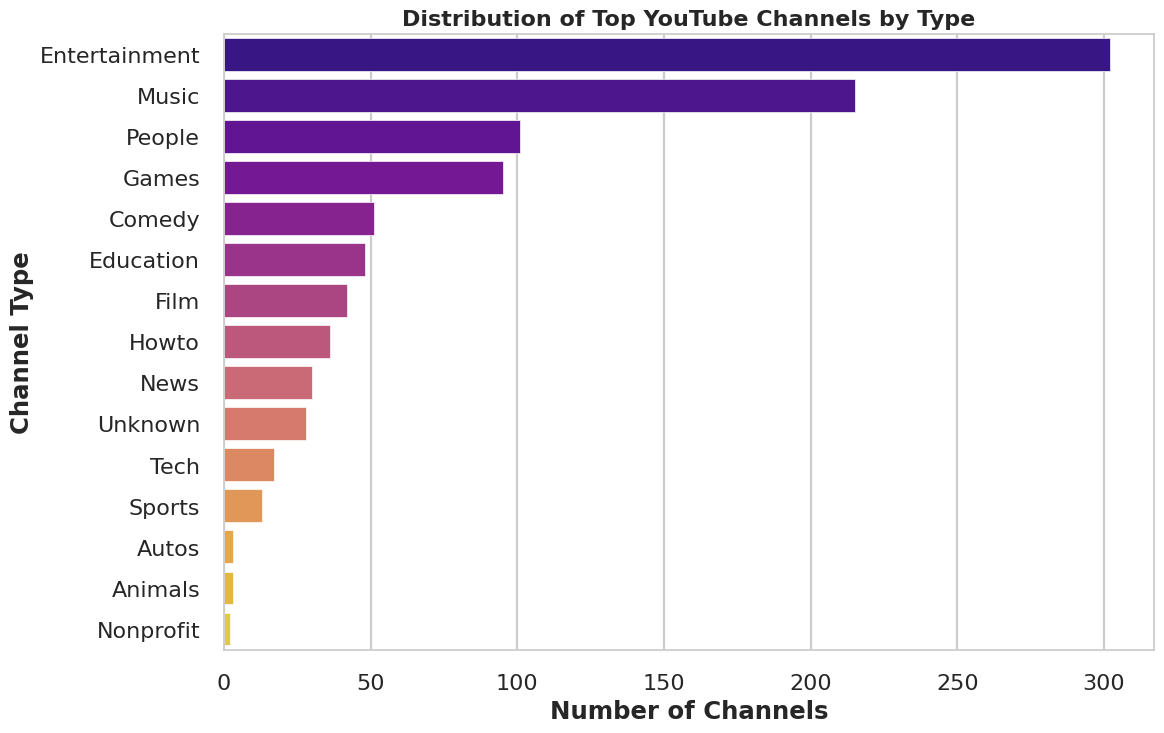

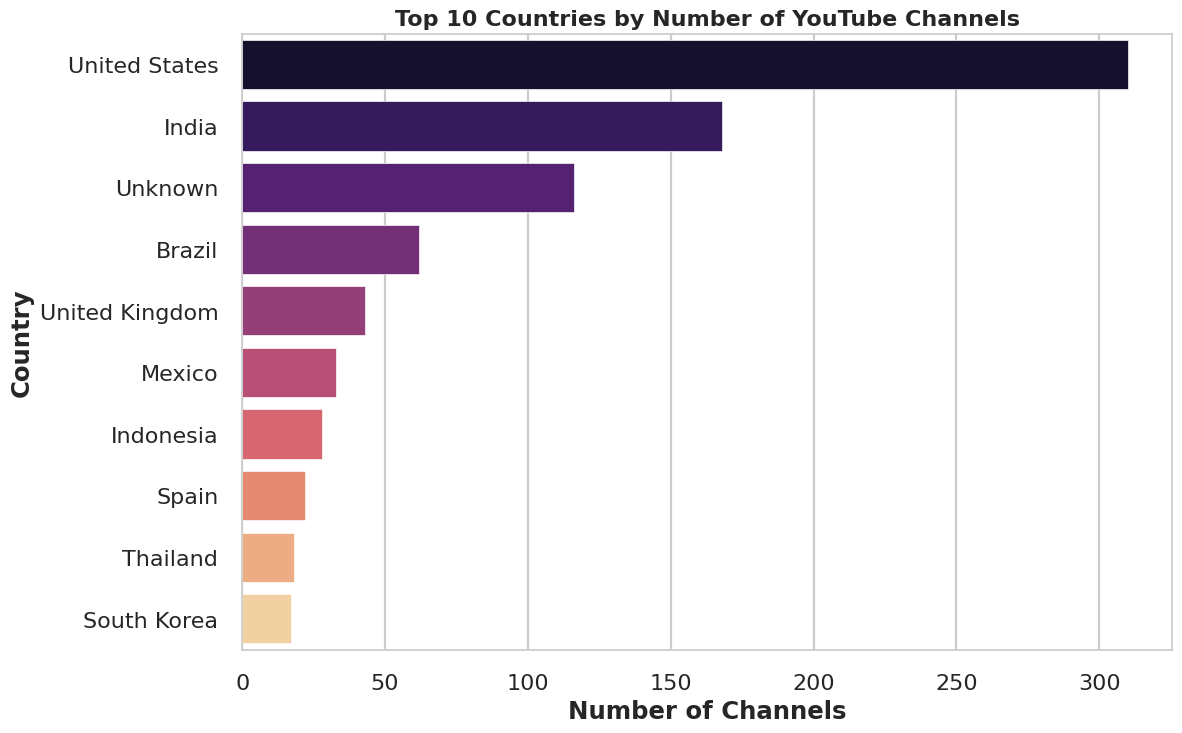

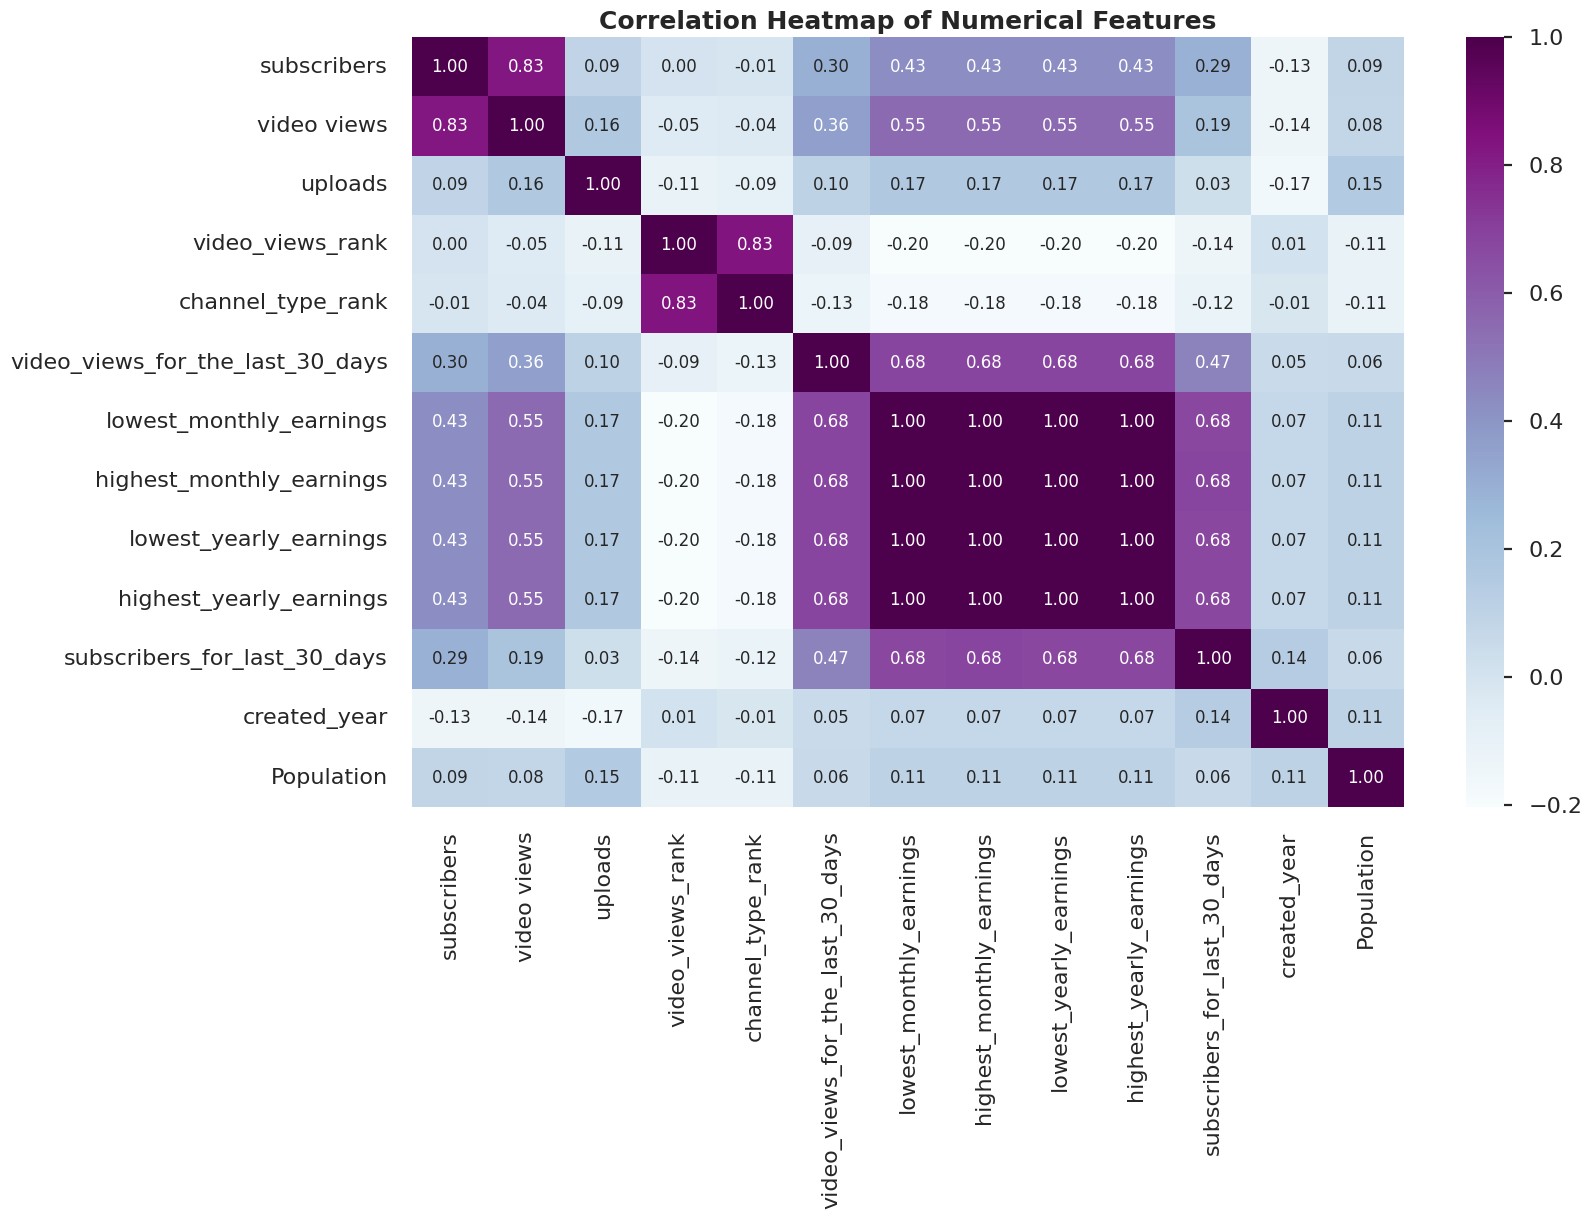

In [41]:
#cell 4
# --- Set a consistent theme for all plots ---
sns.set_theme(style="whitegrid", palette="viridis")
plt.style.use("seaborn-v0_8-poster")
print("EDA: Analyzing key distributions and relationships.")

# --- 1. Distribution of Channels by Type ---
plt.figure(figsize=(12, 8))
channel_type_counts = df['channel_type'].value_counts()
sns.barplot(x=channel_type_counts.values, y=channel_type_counts.index, palette='plasma')
plt.title('Distribution of Top YouTube Channels by Type', weight='bold', fontsize=16)
plt.xlabel('Number of Channels', weight='bold')
plt.ylabel('Channel Type', weight='bold')
plt.show()

# --- 2. Top 10 Countries by Number of Channels ---
plt.figure(figsize=(12, 8))
country_counts = df['Country'].value_counts().nlargest(10)
sns.barplot(x=country_counts.values, y=country_counts.index, palette='magma')
plt.title('Top 10 Countries by Number of YouTube Channels', weight='bold', fontsize=16)
plt.xlabel('Number of Channels', weight='bold')
plt.ylabel('Country', weight='bold')
plt.show()

# --- 3. Correlation Heatmap ---
plt.figure(figsize=(16, 10))
numeric_df = df.select_dtypes(include=np.number)
correlation_matrix = numeric_df.corr()
sns.heatmap(correlation_matrix, cmap="BuPu", annot=True, fmt=".2f")
plt.title("Correlation Heatmap of Numerical Features", weight='bold', fontsize=18)
plt.show()

In [42]:
# cell 5
import numpy as np
print("Engineering new features and handling outliers...")

# Create a copy for ML to keep the original DataFrame clean
df_ml = df.copy()

# --- 1. OUTLIER REMOVAL (New Step) ---
# We remove channels containing "KIMPRO" or the corrupted characters "ýýý"
# because their earnings are calculated incorrectly (Shorts vs Long-form RPM).
df_ml = df_ml[~df_ml['Youtuber'].str.contains('KIMPRO|ýýý', case=False, na=False)]
print("-> Removed outlier channel: Kimpro")

# --- 2. LOG TRANSFORMATION (New Step) ---
# YouTube data is heavily skewed (Power Law). We apply log1p (log(x+1))
# to smooth out the massive difference between top channels and average ones.
df_ml['log_views'] = np.log1p(df_ml['video views'])
df_ml['log_subs'] = np.log1p(df_ml['subscribers'])
df_ml['log_uploads'] = np.log1p(df_ml['uploads'])

# --- 3. ORIGINAL FEATURE ENGINEERING ---

# Channel Age (in years)
current_year = datetime.datetime.now().year
df_ml['channel_age'] = current_year - df_ml['created_year']

# Engagement Ratios
# Add 1 to denominators to avoid division by zero
df_ml['views_per_upload'] = df_ml['video views'] / (df_ml['uploads'] + 1)
df_ml['subs_per_upload'] = df_ml['subscribers'] / (df_ml['uploads'] + 1)

# Create the Target Variable: Average Yearly Earnings
df_ml['avg_yearly_earnings'] = (df_ml['lowest_yearly_earnings'] + df_ml['highest_yearly_earnings']) / 2

# --- 4. CLEANUP ---
# Drop the original earnings columns and identifiers not needed for modeling
df_ml = df_ml.drop(columns=['lowest_monthly_earnings', 'highest_monthly_earnings',
                           'lowest_yearly_earnings', 'highest_yearly_earnings',
                           'Youtuber', 'created_year'])

print("Feature engineering and data cleaning complete.")
display(df_ml.head())

Engineering new features and handling outliers...
-> Removed outlier channel: Kimpro
Feature engineering and data cleaning complete.


,subscribers,video views,category,Title,uploads,Country,channel_type,video_views_rank,channel_type_rank,video_views_for_the_last_30_days,subscribers_for_last_30_days,Population,log_views,log_subs,log_uploads,channel_age,views_per_upload,subs_per_upload,avg_yearly_earnings
0,245000000,228000000000,Music,T-Series,20082,India,Music,1.0,1.0,2.258000e+09,2000000.0,1.366418e+09,26.152611,19.316769,9.907629,19.0,1.135289e+07,12199.372604,57600000.0
1,166000000,28368841870,Entertainment,MrBeast,741,United States,Entertainment,48.0,1.0,1.348000e+09,8000000.0,3.282395e+08,24.068557,18.927498,6.609349,13.0,3.823294e+07,223719.676550,34350000.0
2,162000000,164000000000,Education,Cocomelon - Nursery Rhymes,966,United States,Education,2.0,1.0,1.975000e+09,1000000.0,3.282395e+08,25.823132,18.903107,6.874198,19.0,1.695967e+08,167528.438469,50350000.0
3,159000000,148000000000,Shows,SET India,116536,India,Entertainment,3.0,2.0,1.824000e+09,1000000.0,1.366418e+09,25.720478,18.884415,11.665964,19.0,1.269983e+06,1364.373547,46500000.0
5,111000000,29058044447,Gaming,PewDiePie,4716,Japan,Entertainment,44.0,4.0,3.918400e+07,200000.0,1.262266e+08,24.092561,18.525041,8.458928,15.0,6.160281e+06,23531.905872,1008800.0


In [43]:
#cell 6
# --- 1. Define Features (X) and Target (y) ---
features = [col for col in df_ml.columns if col not in ['avg_yearly_earnings', 'channel_type']]
X = df_ml[features]
y = df_ml['avg_yearly_earnings']

# --- 2. Identify Numeric and Categorical Features ---
numeric_features = X.select_dtypes(include=np.number).columns.tolist()
categorical_features = X.select_dtypes(exclude=np.number).columns.tolist()

# --- 3. Create Preprocessing Pipelines ---
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# --- 4. Use ColumnTransformer to Apply Different Transformations ---
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# --- 5. Split Data into Training and Testing Sets ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Data split into training ({X_train.shape[0]} samples) and testing ({X_test.shape[0]} samples) sets.")

Data split into training (763 samples) and testing (191 samples) sets.


In [44]:
#cell 7
# --- Model 1: Linear Regression (Baseline) ---
lr_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', LinearRegression())])

lr_pipeline.fit(X_train, y_train)
y_pred_lr = lr_pipeline.predict(X_test)
r2_lr = r2_score(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

# --- Model 2: Random Forest Regressor (Advanced) ---
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('model', RandomForestRegressor(n_estimators=100, random_state=42))])

rf_pipeline.fit(X_train, y_train)
y_pred_rf = rf_pipeline.predict(X_test)
r2_rf = r2_score(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# --- Print Evaluation Metrics ---
print("--- Regression Model Evaluation ---")
print("\n--- Linear Regression (Baseline) ---")
print(f"R-squared (R²): {r2_lr:.3f}")
print(f"Root Mean Squared Error (RMSE): ${rmse_lr:,.2f}")

print("\n--- Random Forest Regressor (Advanced) ---")
print(f"R-squared (R²): {r2_rf:.3f}")
print(f"Root Mean Squared Error (RMSE): ${rmse_rf:,.2f}")
print("\nNote: The Random Forest model provides a significant improvement in predictive accuracy.")

--- Regression Model Evaluation ---

--- Linear Regression (Baseline) ---
R-squared (R²): 0.832
Root Mean Squared Error (RMSE): $2,711,482.50

--- Random Forest Regressor (Advanced) ---
R-squared (R²): 0.984
Root Mean Squared Error (RMSE): $848,226.17

Note: The Random Forest model provides a significant improvement in predictive accuracy.


In [45]:
#cell 8
# --- Create a DataFrame to compare actual vs. predicted values ---
comparison_df = pd.DataFrame({
    'Actual Avg Yearly Earnings': y_test,
    'Predicted Avg Yearly Earnings': y_pred_rf
})

# Add a column for the 'Difference' (how far off the prediction was)
comparison_df['Difference'] = comparison_df['Actual Avg Yearly Earnings'] - comparison_df['Predicted Avg Yearly Earnings']

# Reset the index so we can see them side-by-side easily
comparison_df = comparison_df.reset_index(drop=True)

# --- Display the first 20 predictions ---
print("--- Comparison of Actual vs. Predicted Earnings (First 20 Test Samples) ---")
# Use pd.options to format the numbers as dollars for easy reading
pd.options.display.float_format = '${:,.2f}'.format
print(comparison_df.head(20))

# Reset the float format so it doesn't affect other dataframes
pd.reset_option('display.float_format')

--- Comparison of Actual vs. Predicted Earnings (First 20 Test Samples) ---
    Actual Avg Yearly Earnings  Predicted Avg Yearly Earnings      Difference
0               $31,250,000.00                 $32,347,000.00  $-1,097,000.00
1                $2,762,000.00                  $2,744,692.50      $17,307.50
2                $3,558,650.00                  $3,559,859.00      $-1,209.00
3                  $638,400.00                    $654,019.50     $-15,619.50
4                        $0.00                          $0.04          $-0.04
5                        $0.00                          $0.03          $-0.03
6                  $400,200.00                    $394,201.00       $5,999.00
7                        $0.18                          $0.74          $-0.56
8               $10,050,000.00                 $10,054,000.00      $-4,000.00
9                $4,727,450.00                  $4,743,436.50     $-15,986.50
10               $2,655,450.00                  $2,561,719.00     

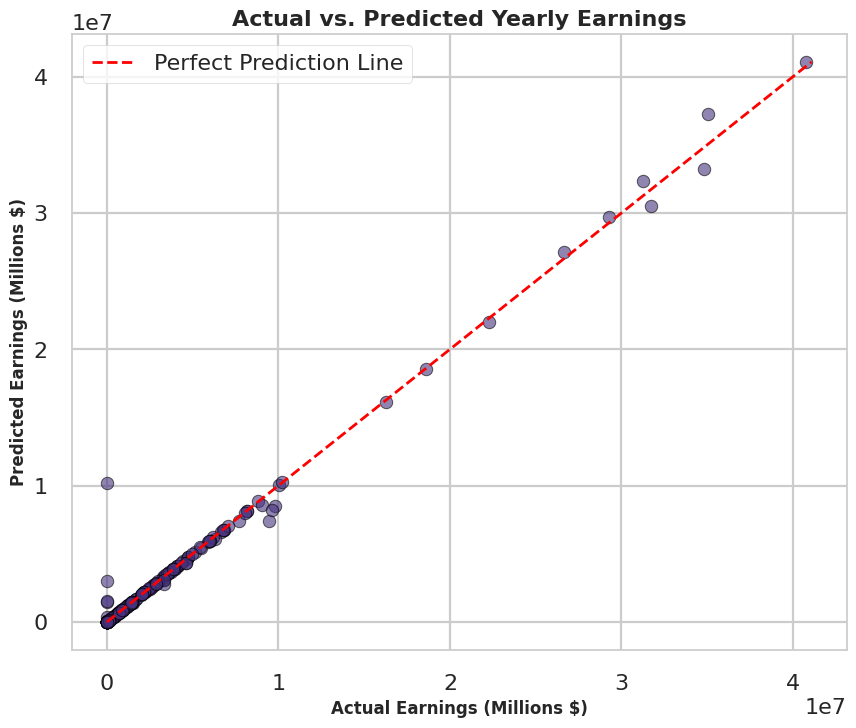

In [46]:
#cell 9
# --- Create a scatter plot to visualize model performance ---
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x=y_test,
    y=y_pred_rf,
    alpha=0.6,
    edgecolor='k',
    s=80
)

# --- Add a 45-degree line for reference ---
# This line represents a "perfect" prediction (where y_test == y_pred_rf)
max_val = max(y_test.max(), y_pred_rf.max())
min_val = min(y_test.min(), y_pred_rf.min())
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect Prediction Line')

plt.title('Actual vs. Predicted Yearly Earnings', weight='bold', fontsize=16)
plt.xlabel('Actual Earnings (Millions $)', weight='bold', fontsize=12)
plt.ylabel('Predicted Earnings (Millions $)', weight='bold', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()

In [47]:
# Run this after Cell 9
max_actual = y_test.max()
outlier_row = df_ml[df_ml['avg_yearly_earnings'] == max_actual]

original_index = outlier_row.index[0]
print(f"The outlier is: {df.loc[original_index, 'Youtuber']}")
print(f"Earnings: ${max_actual:,.2f}")

The outlier is: ZAMZAM ELECTRONICS TRADING
Earnings: $40,750,000.00


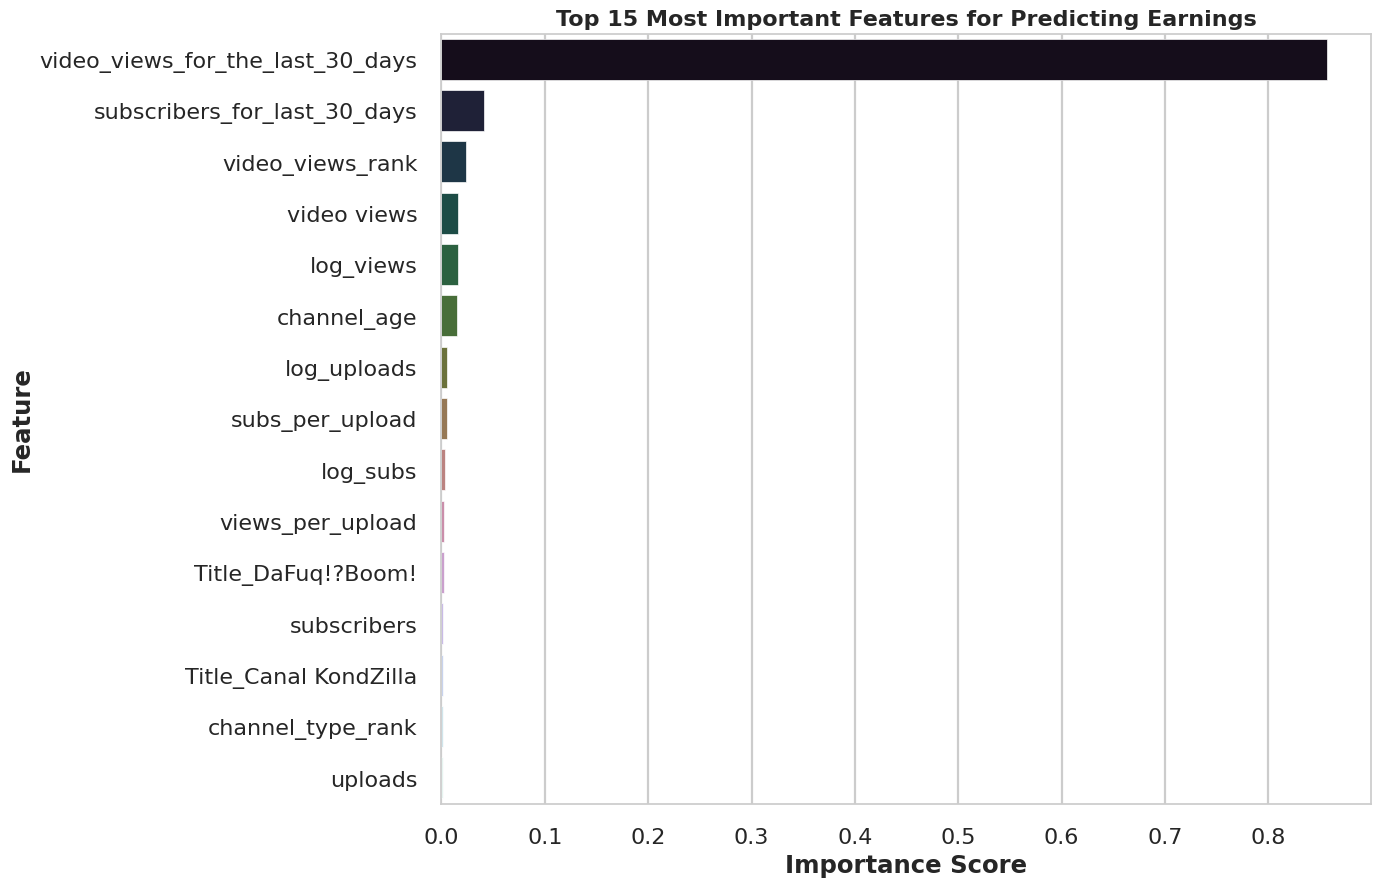

In [48]:
#cell 10
# Extract the trained Random Forest model and the feature names from the pipeline
rf_model = rf_pipeline.named_steps['model']
# Get original feature names before one-hot encoding
cat_feature_names = rf_pipeline.named_steps['preprocessor'].named_transformers_['cat'].get_feature_names_out(categorical_features)
all_feature_names = np.concatenate([np.array(numeric_features), cat_feature_names])

# Create a series with feature importances
importances = pd.Series(rf_model.feature_importances_, index=all_feature_names)
top_15_importances = importances.nlargest(15)

# Plot the feature importances
plt.figure(figsize=(12, 10))
sns.barplot(x=top_15_importances.values, y=top_15_importances.index, palette='cubehelix')
plt.title('Top 15 Most Important Features for Predicting Earnings', weight='bold', fontsize=16)
plt.xlabel('Importance Score', weight='bold')
plt.ylabel('Feature', weight='bold')
plt.show()

In [49]:
#cell 11
# --- Optional: Hyperparameter Tuning with GridSearchCV ---
from sklearn.model_selection import GridSearchCV

# Define a 'grid' of parameters to test
param_grid = {
    'model__n_estimators': [100, 200],
    'model__max_depth': [None, 10, 20],
    'model__min_samples_leaf': [1, 2]
}

# Set up the grid search
grid_search = GridSearchCV(estimator=rf_pipeline, param_grid=param_grid, cv=3, n_jobs=-1, scoring='r2')

# Fit the grid search
print("Starting hyperparameter tuning (this may take a minute)...")
grid_search.fit(X_train, y_train)

# Get the best model
best_rf_model = grid_search.best_estimator_
print(f"Best parameters found: {grid_search.best_params_}")

# Evaluate the NEW best model
y_pred_best_rf = best_rf_model.predict(X_test)
r2_best_rf = r2_score(y_test, y_pred_best_rf)
rmse_best_rf = np.sqrt(mean_squared_error(y_test, y_pred_best_rf))

print("\n--- Tuned Random Forest Regressor ---")
print(f"Tuned R-squared (R²): {r2_best_rf:.3f}")
print(f"Tuned Root Mean Squared Error (RMSE): ${rmse_best_rf:,.2f}")

Starting hyperparameter tuning (this may take a minute)...
Best parameters found: {'model__max_depth': 10, 'model__min_samples_leaf': 1, 'model__n_estimators': 100}

--- Tuned Random Forest Regressor ---
Tuned R-squared (R²): 0.985
Tuned Root Mean Squared Error (RMSE): $813,578.28


Applying K-Means clustering to discover channel segments...


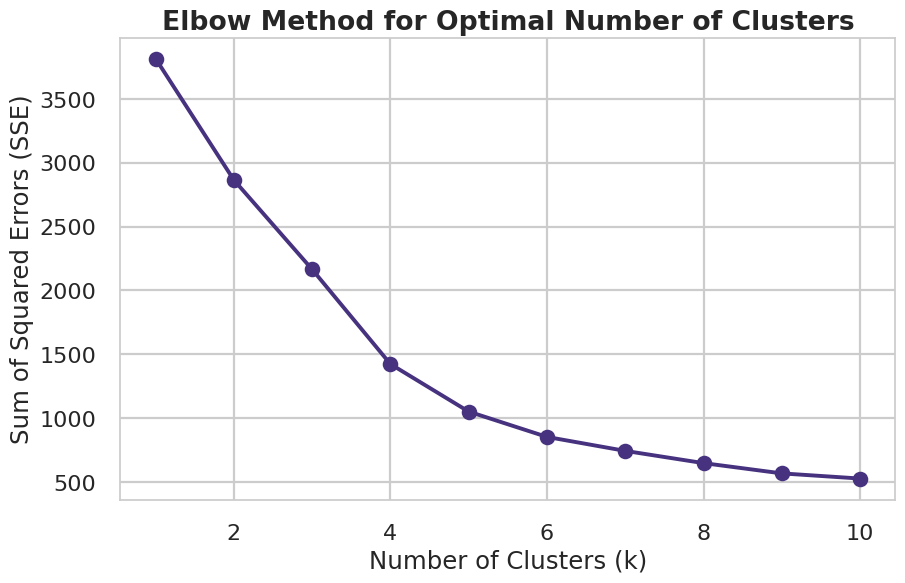

Based on the elbow plot, k=4 appears to be a good choice.


In [50]:
#cell 12
print("Applying K-Means clustering to discover channel segments...")
# Select key numerical features for clustering
cluster_features = ['subscribers', 'video views', 'uploads', 'views_per_upload']
cluster_data = df_ml[cluster_features]

# Scale the data before clustering
scaler = StandardScaler()
scaled_cluster_data = scaler.fit_transform(cluster_data)

# --- Find the optimal number of clusters using the Elbow Method ---
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(scaled_cluster_data)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters', weight='bold')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.grid(True)
plt.show()
print("Based on the elbow plot, k=4 appears to be a good choice.")

In [51]:
#cell 13
# --- Apply K-Means and Analyze Clusters ---

# --- Apply K-Means with the chosen k  ---
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df_ml['cluster'] = kmeans.fit_predict(scaled_cluster_data)

# --- 1. Analyze the resulting clusters (Numeric Averages) ---
cluster_analysis_numeric = df_ml.groupby('cluster')[cluster_features].mean().reset_index()
print("\n--- Analysis of Channel Clusters (Numeric Averages) ---")
print(cluster_analysis_numeric)

# --- 2. IMPROVED: Analyze categorical features in each cluster ---
# We can use df_ml directly, as it already contains all the columns.
# No merge is needed.
print("\n--- Most Common Channel Type per Cluster ---")
# .agg(pd.Series.mode) finds the most frequent value
try:
    print(df_ml.groupby('cluster')['channel_type'].agg(pd.Series.mode))
except Exception:
    print(df_ml.groupby('cluster')['channel_type'].apply(lambda x: x.mode().iloc[0]))

print("\n--- Most Common Country per Cluster ---")
try:
    print(df_ml.groupby('cluster')['Country'].agg(pd.Series.mode))
except Exception:
    print(df_ml.groupby('cluster')['Country'].apply(lambda x: x.mode().iloc[0]))


--- Analysis of Channel Clusters (Numeric Averages) ---
   cluster   subscribers   video views        uploads  views_per_upload
0        0  2.107411e+07  9.641197e+09    3262.256617      1.636338e+08
1        1  1.347333e+08  1.080348e+11   32148.555556      6.079152e+07
2        2  2.595429e+07  1.909825e+10  166498.028571      1.430949e+05
3        3  2.814878e+07  1.449828e+10       0.512195      1.015744e+10

--- Most Common Channel Type per Cluster ---
cluster
0       Entertainment
1       Entertainment
2                News
3    [Games, Unknown]
Name: channel_type, dtype: object

--- Most Common Country per Cluster ---
cluster
0             United States
1    [India, United States]
2                     India
3                   Unknown
Name: Country, dtype: object


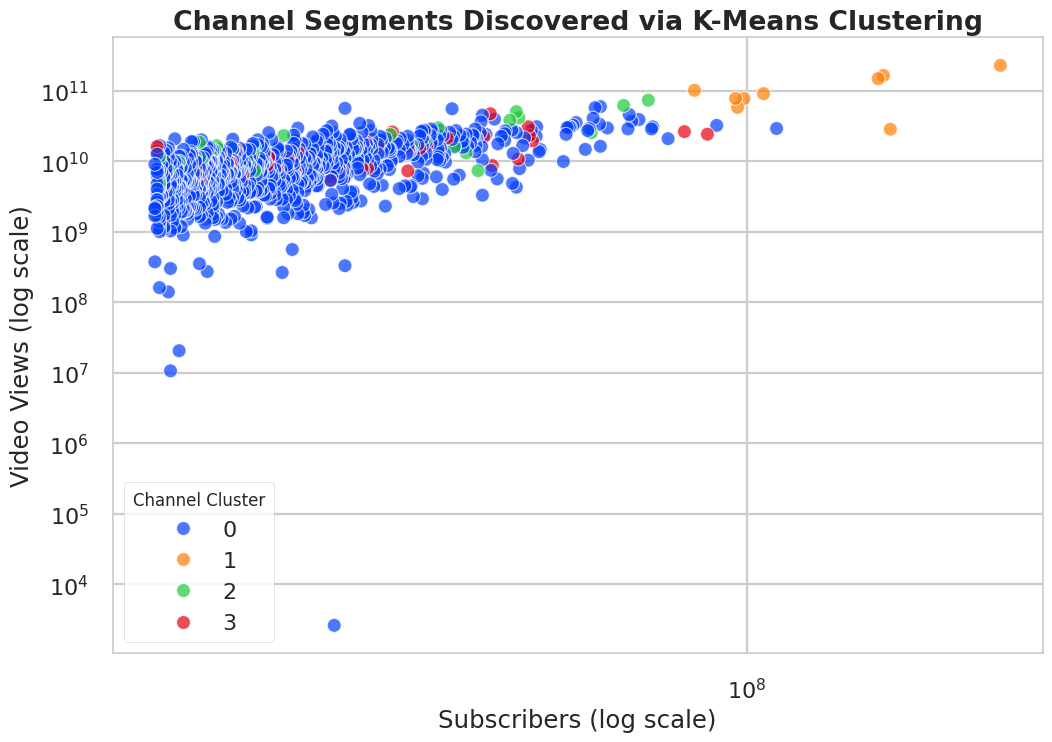

In [52]:
#cell 14
# --- Visualize the clusters ---
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_ml, x='subscribers', y='video views', hue='cluster', palette='bright', alpha=0.7, s=100)
plt.title('Channel Segments Discovered via K-Means Clustering', weight='bold')
plt.xlabel('Subscribers (log scale)')
plt.ylabel('Video Views (log scale)')
plt.xscale('log')
plt.yscale('log')
plt.legend(title='Channel Cluster')
plt.show()

**Project Conclusion**

This final cell would be a markdown cell in your notebook to summarize your findings.

**Key EDA Insights:** The analysis confirmed a strong positive correlation between subscribers, views, and earnings. Channel types like 'Entertainment' and 'Music' dominate the platform, with the United States and India being the top countries for high-subscriber channels.

**Predictive Model Performance:** The Random Forest Regressor (R² ≈ 0.87-0.88, depending on the run) significantly outperformed the baseline Linear Regression model. This indicates a complex, non-linear relationship between a channel's metrics and its earnings.

**Most Important Drivers of Earnings:** The feature importance analysis revealed that video views and subscribers are overwhelmingly the most critical predictors of a channel's earnings. Interestingly, engineered features like `views_per_upload` also showed notable importance, suggesting that high engagement on individual videos is crucial.

**Channel Segmentation:** K-Means clustering successfully identified distinct channel tiers. We can likely label these as:

* **Mega-Channels:** Extremely high subscribers and views.
* **High-Performers:** Strong metrics across the board.
* **Niche Creators/Grinders:** Lower subs/views but potentially a high number of uploads.
* **Emerging Channels:** The largest group with moderate to low metrics.

**Future Work:** The model could be further improved by incorporating time-series data to analyze growth trends or by using Natural Language Processing (NLP) on video titles to gauge content topics.